### Import Tokenizer 

In [1]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

In [2]:
with open('the-verdict.txt',"r",encoding='utf-8') as f:
    raw_text = f.read()

In [3]:
enc_text = tokenizer.encode(raw_text,allowed_special={"<|endoftext|>"})
print(len(enc_text))

5145


### Use of Dataset and DataLoader for parellel processing

In [4]:
from torch.utils.data import Dataset, DataLoader
import torch
class customDataset(Dataset):
    def __init__(self,text,tokenizer,context_len,stride):
        self.input_id = []
        self.target_id = []
        token_ids = tokenizer.encode(text,allowed_special={"<|endoftext|>"})
        for i in range(0,len(token_ids)-context_len,stride):
            input_chunk = token_ids[i:i+context_len]
            target_chunk = token_ids[1+i:1+context_len+i]
            self.input_id.append(torch.tensor(input_chunk))
            self.target_id.append(torch.tensor(target_chunk))
    
    def __len__(self):
        return len(self.input_id) # ceil((len(token_ids)-context_len)/stride) ie, no. of batches
    
    def __getitem__(self,idx):
        return self.input_id[idx],self.target_id[idx]

In [5]:
def dataloader_func(text,batch_size=1,context_len=512,stride=256,shuffle = True,num_worker = 4,drop_last = True):
    tokenizer = tiktoken.get_encoding("gpt2")
    dataset = customDataset(text,tokenizer,context_len,stride)
    dataloader = DataLoader(dataset,batch_size = batch_size,shuffle = shuffle,drop_last = drop_last,num_workers = num_worker,pin_memory = True)
    return dataloader

In [6]:
dataloader = dataloader_func(raw_text,batch_size=4,context_len=4,stride=1,shuffle=True,num_worker=4,drop_last=True)

In [7]:
data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Inputs:\n", inputs)
print("\nTargets:\n", targets)

/home/sayandip-saha/Desktop/CODING/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Inputs:
 tensor([[  286,   366,    38,   271],
        [   13,   520,  5493,   318],
        [  470,   766,   703,   661],
        [  257, 23844,   286,  7543]])

Targets:
 tensor([[  366,    38,   271, 10899],
        [  520,  5493,   318,   262],
        [  766,   703,   661,  6687],
        [23844,   286,  7543,   284]])


### Training Iteration

In [8]:
input_ids = inputs[0]
target_ids = targets[0]

In [9]:
batch_size,context_size = inputs.shape
for i in range(batch_size):
    x = inputs[i] # [ 314,  765,  683,  284]
    y = targets[i] # [ 765,  683,  284, 2883]
    print(f'Processing Batch {i+1}:')
    for j in range(1,context_size+1):
        input = x[:j]
        output = y[j-1]
        print(f'{tokenizer.decode(input.tolist())} ---> {tokenizer.decode([output.item()])}')
    print('\n')

Processing Batch 1:
 of --->  "
 of " ---> G
 of "G ---> is
 of "Gis ---> burn


Processing Batch 2:
. --->  St
. St ---> roud
. Stroud --->  is
. Stroud is --->  the


Processing Batch 3:
't --->  see
't see --->  how
't see how --->  people
't see how people --->  manage


Processing Batch 4:
 a --->  lump
 a lump --->  of
 a lump of --->  sugar
 a lump of sugar --->  to




### Creating token embedding and positional embedding

In [10]:
import torch.nn as nn
vocab_size = tokenizer.n_vocab # size of vocabulary 
embedding_dim = 256 # each token is projected into 256 dimension space

In [11]:
embedding_layer = nn.Embedding(vocab_size,embedding_dim)

In [12]:
print(embedding_layer.weight)

Parameter containing:
tensor([[-0.6146, -0.0652, -1.0227,  ...,  1.3484, -0.3466, -0.3208],
        [ 0.7906,  0.1017, -0.3726,  ...,  0.2276, -1.1347,  0.7830],
        [-0.2455,  0.5377,  0.4168,  ...,  0.8491,  0.8393, -0.1098],
        ...,
        [ 2.4299, -0.8775,  1.0848,  ...,  0.0570,  0.2586, -0.5798],
        [ 1.5216,  2.1748, -2.2819,  ..., -1.0481,  0.0815,  1.0325],
        [-0.3295,  0.4993,  1.3541,  ...,  0.2019,  0.9597, -0.2286]],
       requires_grad=True)


In [13]:
print(embedding_layer(input_ids))

tensor([[-0.7805, -1.8027,  1.7052,  ...,  2.1712, -0.0753, -0.8142],
        [ 0.1399,  0.5961,  1.1065,  ..., -1.7707, -1.5838, -0.5572],
        [ 0.0889,  0.0780, -1.7192,  ...,  1.3707, -0.7442, -2.1587],
        [-0.2240, -0.8380, -1.3884,  ..., -0.1448, -2.2344, -2.3870]],
       grad_fn=<EmbeddingBackward0>)


In [14]:
print(embedding_layer(target_ids))

tensor([[ 0.1399,  0.5961,  1.1065,  ..., -1.7707, -1.5838, -0.5572],
        [ 0.0889,  0.0780, -1.7192,  ...,  1.3707, -0.7442, -2.1587],
        [-0.2240, -0.8380, -1.3884,  ..., -0.1448, -2.2344, -2.3870],
        [ 0.5854,  0.6044, -0.8283,  ..., -0.8332,  0.7290, -0.4155]],
       grad_fn=<EmbeddingBackward0>)


In [15]:
inputs

tensor([[  286,   366,    38,   271],
        [   13,   520,  5493,   318],
        [  470,   766,   703,   661],
        [  257, 23844,   286,  7543]])

In [16]:
print("Max token index in inputs:", inputs.max().item())
print("Embedding vocab size:", embedding_layer.num_embeddings)


Max token index in inputs: 23844
Embedding vocab size: 50257


In [17]:
token_embedding = embedding_layer(inputs)

In [18]:
print(token_embedding.shape)

torch.Size([4, 4, 256])


In [19]:
pos_embedding_layer = nn.Embedding(context_size,embedding_dim)

In [20]:
pos_embedding = pos_embedding_layer(torch.arange(context_size))

In [21]:
input_embedding = token_embedding + pos_embedding

In [22]:
input_embedding

tensor([[[-0.6146, -1.7022,  2.5253,  ...,  1.9071,  0.4057, -0.2411],
         [ 1.0809,  0.7591,  0.3673,  ..., -0.5335, -2.7756,  1.2426],
         [-0.8084, -0.1466, -0.9512,  ...,  0.7597, -0.4429, -3.1417],
         [ 1.1338, -1.8042, -2.1049,  ..., -0.6132, -2.5058, -2.4856]],

        [[ 0.9687,  1.3060, -0.3877,  ...,  0.3672, -1.0589, -0.1055],
         [ 1.6497,  0.4791, -1.4647,  ...,  1.4321, -1.2683,  2.7148],
         [ 0.3469, -0.6864, -0.4211,  ..., -0.5019,  1.3682, -1.0805],
         [ 2.3402, -1.3706,  0.3969,  ...,  0.0215,  0.9327,  0.7648]],

        [[ 0.2408,  1.4191,  0.7681,  ..., -0.4455, -0.6550,  0.2906],
         [ 1.9625, -1.0407, -2.4381,  ...,  1.7013, -2.0127,  2.0650],
         [-1.2864,  0.6912,  2.2582,  ...,  0.0938, -1.7301, -2.2027],
         [ 0.5442, -2.3517, -0.5185,  ..., -0.1114, -0.5864,  0.6941]],

        [[-0.9254,  2.0184,  1.2581,  ..., -1.5170,  0.8226, -0.3472],
         [ 1.9573,  0.9839, -2.3463,  ...,  1.1042, -0.9541,  1.3984],


### MULTIHEAD SELF ATTENTION 

In [23]:
inputs

tensor([[  286,   366,    38,   271],
        [   13,   520,  5493,   318],
        [  470,   766,   703,   661],
        [  257, 23844,   286,  7543]])

In [24]:
for i in range(inputs.shape[0]):
    for j in range(inputs.shape[1]):
        print((tokenizer.decode([inputs[i][j].item()])),end=" ")
    print("\n")

 of  " G is 

.  St roud  is 

't  see  how  people 

 a  lump  of  sugar 



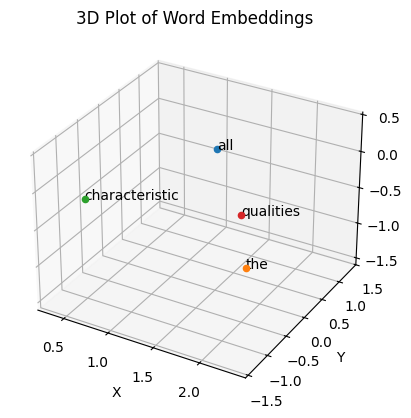

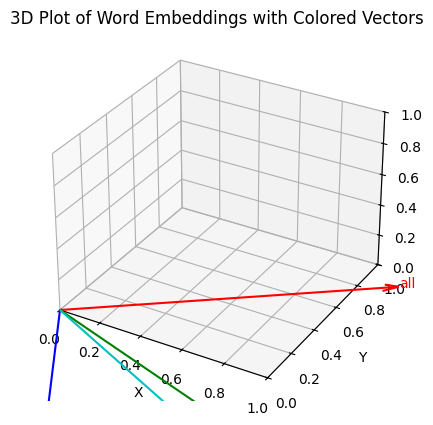

In [25]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

inputs2 = input_embedding[1]

# Corresponding words
words2 = ['all', 'the', 'characteristic', 'qualities']

# Extract x, y, z coordinates
x_coords = inputs2[:, 0].detach().numpy()
y_coords = inputs2[:, 1].detach().numpy()
z_coords = inputs2[:, 2].detach().numpy()


# Create 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot each point and annotate with corresponding word
for x, y, z, word in zip(x_coords, y_coords, z_coords, words2):
    ax.scatter(x, y, z)
    ax.text(x, y, z, word, fontsize=10)

# Set labels for axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.title('3D Plot of Word Embeddings')
plt.show()

# Create 3D plot with vectors from origin to each point, using different colors
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Define a list of colors for the vectors
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'r']

# Plot each vector with a different color and annotate with the corresponding word
for (x, y, z, word, color) in zip(x_coords, y_coords, z_coords, words2, colors):
    # Draw vector from origin to the point (x, y, z) with specified color and smaller arrow length ratio
    ax.quiver(0, 0, 0, x, y, z, color=color, arrow_length_ratio=0.05)
    ax.text(x, y, z, word, fontsize=10, color=color)

# Set labels for axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set plot limits to keep arrows within the plot boundaries
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_zlim([0, 1])

plt.title('3D Plot of Word Embeddings with Colored Vectors')
plt.show()

In [26]:
import torch.nn as nn
class multihead_self_attention(nn.Module):
    def __init__(self,d_in,d_out,context_len,dropout,num_heads,qkv_bias):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "output dimension evenly distributed among each heads"
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = self.d_out // self.num_heads
        self.proj = nn.Linear(d_out,d_out,bias=qkv_bias)
        self.w_key = nn.Linear(d_in,d_out,bias=qkv_bias)
        self.w_query = nn.Linear(d_in,d_out,bias=qkv_bias)
        self.w_value = nn.Linear(d_in,d_out,bias=qkv_bias)
        self.dropout = dropout
        self.context_len = context_len
        self.register_buffer('mask',torch.triu(torch.ones(context_len,context_len),diagonal=1))

    def forward(self,input):
        batch_size,num_tokens,d_in = input.shape
        keys = self.w_key(input) # (batch_size,num_tokens,d_out)
        quaries = self.w_query(input)
        values = self.w_value(input) 

        keys = keys.view(batch_size,num_tokens,self.num_heads,self.head_dim) # (batch_size,num_tokens,num_heads,head_dim)
        quaries = quaries.view(batch_size,num_tokens,self.num_heads,self.head_dim)
        values = values.view(batch_size,num_tokens,self.num_heads,self.head_dim)

        keys = keys.transpose(1,2) # (batch_size,num_heads,num_tokens,head_dim)
        quaries = quaries.transpose(1,2)
        values = values.transpose(1,2)

        attn_score = quaries @ keys.transpose(2,3) # (batch_size, num_heads, num_tokens, num_tokens)
        # attn_score.masked_fill_(self.mask.bool()[:num_tokens][:num_tokens],-torch.inf)
        attn_score.masked_fill_(
            self.mask[:num_tokens, :num_tokens].bool(),
            float('-inf')
        )
        attn_weights = torch.softmax(attn_score/keys.shape[-1]**0.5,dim=-1)
        context_vec = attn_weights @ values # (batch_size,num_heads,num_tokens,head_dim)
        context_vec = context_vec.transpose(1,2)# (batch_size,num_tokens,num_heads,head_dim)
        context_vec = context_vec.contiguous().view(batch_size,num_tokens,self.d_out)
        context_vec = self.proj(context_vec)
        return context_vec

In [27]:
batch_size,num_tokens,d_in = input_embedding.shape
d_out = d_in
model = multihead_self_attention(d_in,d_out,num_tokens,0.5,2,False)
context_vec = model(input_embedding)
print(context_vec)
print(f'Context Vector shape: {context_vec.shape}')

tensor([[[ 0.1473,  1.7889,  0.0121,  ..., -0.0071,  0.7642,  0.2436],
         [ 0.4042,  0.8808,  0.0781,  ..., -0.0496,  0.0261,  0.2992],
         [ 0.4070,  0.4451,  0.2616,  ..., -0.0089, -0.1939,  0.3131],
         [ 0.3326,  0.2222,  0.2319,  ...,  0.1919, -0.1793,  0.1041]],

        [[ 0.0990,  1.1633,  0.2201,  ...,  0.0736,  0.1221, -0.1173],
         [-0.4366,  1.1562, -0.3004,  ...,  0.2350,  0.1610, -0.2196],
         [ 0.1364,  0.0262,  0.2201,  ..., -0.0617, -0.1856,  0.6087],
         [ 0.0870,  0.4794,  0.2854,  ...,  0.0670, -0.0796,  0.0440]],

        [[-0.3240,  1.3568,  0.1986,  ...,  0.7572,  0.6961, -0.7727],
         [ 0.1249,  1.1215,  0.1913,  ...,  0.4912,  0.2864, -0.5066],
         [-0.3131,  0.6724,  0.3875,  ...,  0.2550,  0.2163, -0.1235],
         [-0.2550,  0.1610,  0.4287,  ...,  0.1951, -0.0347,  0.1800]],

        [[ 0.6831,  0.9309,  0.0450,  ..., -0.2884, -0.0523, -0.7544],
         [ 0.2950,  0.3077,  0.0747,  ..., -0.2449,  0.0625, -0.3106],


### Next Part

In [28]:
input_embedding

tensor([[[-0.6146, -1.7022,  2.5253,  ...,  1.9071,  0.4057, -0.2411],
         [ 1.0809,  0.7591,  0.3673,  ..., -0.5335, -2.7756,  1.2426],
         [-0.8084, -0.1466, -0.9512,  ...,  0.7597, -0.4429, -3.1417],
         [ 1.1338, -1.8042, -2.1049,  ..., -0.6132, -2.5058, -2.4856]],

        [[ 0.9687,  1.3060, -0.3877,  ...,  0.3672, -1.0589, -0.1055],
         [ 1.6497,  0.4791, -1.4647,  ...,  1.4321, -1.2683,  2.7148],
         [ 0.3469, -0.6864, -0.4211,  ..., -0.5019,  1.3682, -1.0805],
         [ 2.3402, -1.3706,  0.3969,  ...,  0.0215,  0.9327,  0.7648]],

        [[ 0.2408,  1.4191,  0.7681,  ..., -0.4455, -0.6550,  0.2906],
         [ 1.9625, -1.0407, -2.4381,  ...,  1.7013, -2.0127,  2.0650],
         [-1.2864,  0.6912,  2.2582,  ...,  0.0938, -1.7301, -2.2027],
         [ 0.5442, -2.3517, -0.5185,  ..., -0.1114, -0.5864,  0.6941]],

        [[-0.9254,  2.0184,  1.2581,  ..., -1.5170,  0.8226, -0.3472],
         [ 1.9573,  0.9839, -2.3463,  ...,  1.1042, -0.9541,  1.3984],


In [29]:
input_embedding.shape

torch.Size([4, 4, 256])

In [30]:
GPT_CONFIG_124M = {
    "vocab_size" : 50257,
    "emb_dim" : 768,
    "context_len" : 1024,
    "n_heads" : 12,
    "n_layers" : 12,
    "drop_rate" : 0.5,
    "qkv_bias" : False
}

In [31]:
import torch
import torch.nn as nn
class GPT_Model(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"],cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_len"],cfg["emb_dim"])
        self.drop_layer = nn.Dropout(cfg["drop_rate"])
        self.transformer = nn.Sequential(
            *[transformer_block(cfg) for _ in range(cfg["n_layers"])]
        )
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"],cfg["vocab_size"])
    def forward(self,in_idx):
        batch_size,seq_len = in_idx.shape
        token_emb = self.tok_emb(in_idx)
        pos_emb = self.pos_emb(torch.arange(seq_len))
        x = token_emb + pos_emb
        x = self.transformer(x)
        x = self.final_norm(x)
        x = self.out_head(x)
        return x
    
class LayerNorm(nn.Module):
    def __init__(self,normalized_shape,eps=1e-5):
        super().__init__()
        self.normalized_shape = normalized_shape
        self.weights = nn.Parameter(torch.ones(normalized_shape))
        self.biases = nn.Parameter(torch.zeros(normalized_shape))
        self.eps = eps
    def forward(self,x):
        mean = x.mean(dim=-1,keepdim=True)
        var = x.var(dim=-1,keepdim=True,unbiased=True)
        x_norm = (x-mean) / torch.sqrt(var+self.eps)
        x = x_norm*self.weights + self.biases
        return x

class transformer_block(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        self.ln1 = LayerNorm(cfg["emb_dim"])
        self.mha = multihead_self_attention(d_in=cfg["emb_dim"],d_out=cfg["emb_dim"],context_len=cfg["context_len"],dropout=cfg["drop_rate"],num_heads=cfg["n_heads"],qkv_bias=cfg["qkv_bias"])
        self.ln2 = LayerNorm(cfg["emb_dim"])
        self.ff = nn.Sequential(
            nn.Linear(cfg["emb_dim"],4*cfg["emb_dim"]),
            nn.GELU(),
            nn.Linear(4*cfg["emb_dim"],cfg["emb_dim"])
        )
        self.drop_layer = nn.Dropout(cfg["drop_rate"])
    def forward(self,x):
        attn_out = self.mha(self.ln1(x))
        x = x + attn_out
        ff_out = self.ff(self.ln2(x))
        out = self.drop_layer(ff_out)
        res = x + out
        return out

In [32]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [33]:
torch.manual_seed(123)
model = GPT_Model(GPT_CONFIG_124M)
logits = model(batch)
print("Output shape:", logits.shape)
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-1.0752,  0.0421, -0.2490,  ...,  0.8811,  0.3777, -0.2084],
         [ 0.1110,  0.0576, -0.4207,  ...,  0.2749,  0.2145, -0.1129],
         [-0.6740, -0.4367,  0.0027,  ..., -0.0384, -0.6905,  0.0079],
         [-0.8293, -0.5622, -0.5264,  ..., -0.0543, -0.5938,  0.2150]],

        [[-0.1996, -0.9791,  0.5351,  ...,  0.8083,  0.8722,  0.1695],
         [ 0.0841,  0.7575,  0.6302,  ...,  1.0753,  0.4486,  1.1114],
         [ 0.2591, -0.3957,  0.5953,  ...,  0.2247, -1.2295,  1.1365],
         [-0.1326, -0.1661, -0.4231,  ...,  0.4086, -0.6818, -0.3500]]],
       grad_fn=<ViewBackward0>)


### Transformer Block Coding

In [34]:
GPT_CONFIG_124M = {
    "vocab_size" : 50257,
    "emb_dim" : 768,
    "context_len" : 256,
    "n_heads" : 12,
    "n_layers" : 12,
    "drop_rate" : 0.5,
    "qkv_bias" : False
}

In [35]:
class Layer_Normalization(nn.Module):
    def __init__(self,embedding_dim):
        super().__init__()
        self.weights = nn.Parameter(torch.ones(embedding_dim))
        self.biases = nn.Parameter(torch.zeros(embedding_dim))
        self.eps = 1e-5
    def forward(self,x):
        mean = x.mean(dim=-1,keepdim=True)
        var = x.var(dim=-1,keepdim=True,unbiased=False)
        norm_x = (x-mean) / torch.sqrt(self.eps+var)
        return self.weights * norm_x + self.biases

In [36]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self,x):
        return 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2.0 /torch.pi)) * (x + 0.044715 * torch.pow(x,3))))

In [37]:
class FeedForward_NN(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(cfg['emb_dim'], 4*cfg['emb_dim']),
            GELU(),
            nn.Linear(4*cfg['emb_dim'],cfg['emb_dim'])
        )
    def forward(self,x):
        return self.layer(x)

In [38]:
class Transformer_Block(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        self.attn_module = multihead_self_attention(
            d_in = cfg['emb_dim'],
            d_out = cfg['emb_dim'],
            context_len = cfg['context_len'],
            dropout = cfg['drop_rate'],
            num_heads = cfg['n_heads'],
            qkv_bias = cfg['qkv_bias'],
        )
        self.ff = FeedForward_NN(cfg)
        self.norm1 = Layer_Normalization(cfg['emb_dim'])
        self.norm2 = Layer_Normalization(cfg['emb_dim'])
        self.drop_out = nn.Dropout(cfg['drop_rate'])
    
    def forward(self,x):
        shortcut = x
        x = self.norm1(x)
        x = self.attn_module(x)
        x = self.drop_out(x)
        x = x + shortcut

        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_out(x)
        x = x + shortcut
        return x


In [39]:
import torch
import torch.nn as nn
class GPT_Model(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        self.token_emb = nn.Embedding(cfg['vocab_size'],cfg['emb_dim'])
        self.pos_emb = nn.Embedding(cfg['context_len'],cfg['emb_dim'])
        self.drop_emb = nn.Dropout(cfg['drop_rate'])

        self.trf_block = nn.Sequential(
            *[Transformer_Block(cfg) for _ in range(cfg['n_layers'])])
        self.norm = Layer_Normalization(cfg['emb_dim'])
        self.out_head = nn.Linear(cfg['emb_dim'],cfg['vocab_size'],bias=False)
    
    def forward(self,x):
        batch_size,seq_len = x.shape
        token_embeddings = self.token_emb(x)
        pos_indices = torch.arange(seq_len,device=x.device).unsqueeze(0)
        positional_embeddings = self.pos_emb(pos_indices)
        x = token_embeddings + positional_embeddings
        x = self.drop_emb(x)
        x = self.trf_block(x)
        x = self.norm(x)
        logits = self.out_head(x)
        return logits

In [40]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch,dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [41]:
torch.manual_seed(123)
model = GPT_Model(GPT_CONFIG_124M)
logits = model(batch)
print(f'Batch size: {batch.shape}')
print(f'Output dimension: {logits.shape}')
print(f'Input Batches: \n{batch}')
print(f'Output logits: \n{logits}')

Batch size: torch.Size([2, 4])
Output dimension: torch.Size([2, 4, 50257])
Input Batches: 
tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])
Output logits: 
tensor([[[-0.6105, -1.0860,  0.8264,  ...,  0.0407, -0.1214, -0.5458],
         [-0.7059,  0.3137,  0.4096,  ..., -0.1400, -0.8901, -0.7963],
         [ 0.3430,  0.3486,  0.7116,  ...,  0.4304,  0.3793,  0.3669],
         [ 0.6215,  1.1878, -0.6271,  ...,  0.2725,  0.2158, -0.1652]],

        [[-0.6235, -0.6989, -0.2467,  ..., -0.4446, -0.3357,  0.7554],
         [-0.9635,  0.2748, -0.5600,  ..., -0.5493, -1.1388, -0.9079],
         [-1.1849, -0.1853, -0.8579,  ..., -0.5580, -0.7881, -0.2976],
         [-0.9961, -0.0028, -0.2638,  ..., -0.4068, -0.3990,  0.7136]]],
       grad_fn=<UnsafeViewBackward0>)


In [42]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 162,410,496


In [43]:
total_size_bytes = total_params * 4 #A
total_size_mb = total_size_bytes / (1024 * 1024) #B
print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 619.55 MB


In [104]:
def generate_text_simple(model,batch,context_size,temperature=0.0, top_k=None, max_new_tokens=20, eos_id=None):
    for _ in range(max_new_tokens):
        batch_size,seq_len = batch.shape
        batch_input = batch[:,-context_size:] # (batch_size,context_size) only consider context_size no of tokens as input for model
        with torch.no_grad():
            logits = model(batch_input) # (batch_size,context_size,vocab_size)
        
        logits = logits[:,-1,:]

        if top_k is not None:
            top_logits,_ = torch.topk(logits,top_k)
            min_val = top_logits[:,-1]
            logits = torch.where(logits < min_val ,torch.tensor(float("-inf")).to(logits.device), logits) 
        
        if temperature > 0.0:
            logits = logits/temperature
            probas = torch.softmax(logits,dim=-1)
            next_token = torch.multinomial(probas,num_samples=1)
            pass
        else:
            probs = torch.softmax(logits,dim=-1)
            next_token = torch.argmax(probs,dim=-1,keepdim=True)
        
        if next_token == eos_id : break
        batch = torch.cat((batch,next_token),dim=1)
    return batch

In [105]:
model.eval()
out = generate_text_simple(model = model,batch = batch,context_size=GPT_CONFIG_124M['context_len'],max_new_tokens=6)
print(f'Input shape: {batch.shape}')
print(f'Output shape: {out.shape}')
print(f'Input: \n{batch}')
print(f'Output: \n{out}')

Input shape: torch.Size([2, 4])
Output shape: torch.Size([2, 10])
Input: 
tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])
Output: 
tensor([[6109, 3626, 6100,  345,   13,  198,  198,  198,  198,  198],
        [6109, 1110, 6622,  257,   13,  198,  198,  198,  198,  198]])


In [106]:
for i in range(batch.shape[0]):
    decoded_input_text = tokenizer.decode(batch[i].tolist())
    print(f'{decoded_input_text} -> ')
    decoded_output_text = tokenizer.decode(out[i].tolist())
    print(f'{decoded_output_text}\n')


Every effort moves you -> 
Every effort moves you.






Every day holds a -> 
Every day holds a.








### New session


In [107]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

In [108]:
with torch.no_grad():
    logits = model(inputs)

probas = torch.softmax(logits,dim=-1)
print(probas)

tensor([[[3.1274e-04, 2.5623e-03, 1.1770e-05,  ..., 8.0163e-06,
          1.1073e-05, 1.2266e-05],
         [2.8434e-04, 2.7478e-03, 1.1672e-05,  ..., 7.8042e-06,
          1.0410e-05, 1.1475e-05],
         [3.0494e-04, 2.6948e-03, 1.3192e-05,  ..., 8.0700e-06,
          1.0900e-05, 1.2331e-05]],

        [[2.9404e-04, 2.5410e-03, 1.1967e-05,  ..., 8.2368e-06,
          1.1531e-05, 1.2314e-05],
         [2.8790e-04, 2.6150e-03, 1.1283e-05,  ..., 8.1150e-06,
          1.0303e-05, 1.1952e-05],
         [2.9499e-04, 2.5568e-03, 1.2054e-05,  ..., 7.9880e-06,
          1.0893e-05, 1.2080e-05]]])


In [109]:
token_ids = torch.argmax(probas,dim=-1,keepdim=True)
print(f'Token IDs: \n {token_ids}')

Token IDs: 
 tensor([[[ 11],
         [198],
         [ 13]],

        [[ 11],
         [ 11],
         [ 13]]])


In [110]:
import tiktoken

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())


In [111]:
print(f'Target batch 1:{token_ids_to_text(targets[0],tokenizer=tokenizer)}')
print(f'Output batch 1:{token_ids_to_text(token_ids[0].flatten(),tokenizer=tokenizer)}')

Target batch 1: effort moves you
Output batch 1:,
.


In [112]:
targets.shape

torch.Size([2, 3])

In [113]:
output_probas_list = []
for text_idx in range(targets.shape[0]):
    target_probas_i = probas[text_idx, [0,1,2], targets[text_idx]]
    output_probas_list.append(target_probas_i)
    print(f"Probabilities for Text {text_idx+1}: {target_probas_i}")

final_tensor = torch.cat(output_probas_list)
print(final_tensor)

Probabilities for Text 1: tensor([3.9819e-05, 1.3841e-05, 5.2715e-04])
Probabilities for Text 2: tensor([2.2943e-04, 7.0857e-05, 6.0629e-06])
tensor([3.9819e-05, 1.3841e-05, 5.2715e-04, 2.2943e-04, 7.0857e-05, 6.0629e-06])


In [114]:
log_probas = torch.log(torch.cat(output_probas_list))
print(log_probas)

tensor([-10.1312, -11.1878,  -7.5480,  -8.3799,  -9.5548, -12.0133])


In [115]:
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-9.8025)


In [116]:
neg_avg_log_probas = avg_log_probas*-1
print(neg_avg_log_probas)

tensor(9.8025)


In [117]:
loss = torch.nn.functional.cross_entropy(logits.flatten(0,1),targets.flatten())
print(loss)

tensor(9.8025)


In [118]:
print(f'Perplexity score: {torch.exp(loss)}')

Perplexity score: 18079.34765625


### Training Iterations

In [119]:
import os
import urllib.request

file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
        text_data = response.read().decode('utf-8')
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

In [120]:
# First 100 characters
print(text_data[:99])

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


In [121]:
len(text_data)

20479

In [122]:
import tiktoken
tokenizer= tiktoken.get_encoding("gpt2")

In [123]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


In [124]:
# Train/validation ratio
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]


torch.manual_seed(123)

train_loader = dataloader_func(
    train_data,
    batch_size=2,
    context_len=GPT_CONFIG_124M["context_len"],
    stride=GPT_CONFIG_124M["context_len"],
    drop_last=True,
    shuffle=True,
    num_worker=0
)

val_loader = dataloader_func(
    val_data,
    batch_size=2,
    context_len=GPT_CONFIG_124M["context_len"],
    stride=GPT_CONFIG_124M["context_len"],
    drop_last=False,
    shuffle=False,
    num_worker=0
)

In [125]:
# Sanity check

if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_len"]:
    print("Not enough tokens for the training loader. "
          "Try to lower the `GPT_CONFIG_124M['context_len']` or "
          "increase the `training_ratio`")

if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_len"]:
    print("Not enough tokens for the validation loader. "
          "Try to lower the `GPT_CONFIG_124M['context_len']` or "
          "decrease the `training_ratio`")

In [126]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [127]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 4608
Validation tokens: 512
All tokens: 5120


In [128]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [129]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Note:
# Uncommenting the following lines will allow the code to run on Apple Silicon chips, if applicable,
# which is approximately 2x faster than on an Apple CPU (as measured on an M3 MacBook Air).
# However, the resulting loss values may be slightly different.

#if torch.cuda.is_available():
#    device = torch.device("cuda")
#elif torch.backends.mps.is_available():
#    device = torch.device("mps")
#else:
#    device = torch.device("cpu")
#
# print(f"Using {device} device.")


model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes


torch.manual_seed(123) # For reproducibility due to the shuffling in the data loader

with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 7.288107395172119
Validation loss: 7.541026592254639


In [130]:
def evaluate_model(model,train_loader,val_loader,device,eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader,model,device,num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader,model,device,num_batches=eval_iter)
    model.train()
    return train_loss,val_loss

In [131]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, batch=encoded,temperature=1.4,top_k=25,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

In [132]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel() # Returns the total number of elements (or tokens) in the input_batch.
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0: 
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen

In [133]:
# Note:
# Uncomment the following code to calculate the execution time
import time
start_time = time.time()

torch.manual_seed(123)
model = GPT_Model(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

# Note:
# Uncomment the following code to show the execution time
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 9.856, Val loss 10.163
Ep 1 (Step 000005): Train loss 8.235, Val loss 8.363
Every effort moves you--, of he. the he to his was;.,. I the. he of to the,. ---- to, I the he,.. .  ,--- was to it--, it  of,
Ep 2 (Step 000010): Train loss 6.886, Val loss 7.160
Ep 2 (Step 000015): Train loss 6.269, Val loss 6.677
Every effort moves you had the-"-- he in a that,--, the "",,, in had his-- to to it . of" I, had with" my his in" the",. him and, he , " the
Ep 3 (Step 000020): Train loss 6.055, Val loss 6.638
Ep 3 (Step 000025): Train loss 5.993, Val loss 6.669
Every effort moves you G I, to G. of a " to a a, to the's her on had  of a "--,, the of the. his and.'s his  on.'s and." ", of that- he  
Ep 4 (Step 000030): Train loss 5.941, Val loss 6.689
Ep 4 (Step 000035): Train loss 5.892, Val loss 6.772
Every effort moves you. . the, had to was, was of of to it a- that was.     " of the I, the- to, of the it his that and the had, he as of the to of the-- had
Ep 5 (Step 

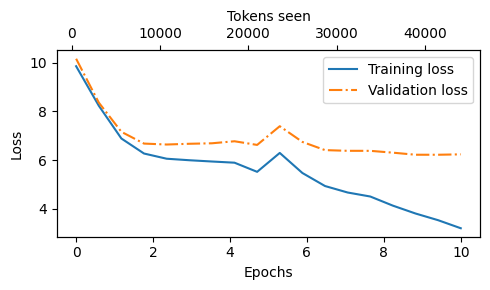

In [134]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [136]:
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict()
}, "model_and_optimizer.pth")
